YAMNet Feature Extraction

Extract 1024-dimensional embeddings from preprocessed audio frames
using the pre-trained YAMNet model as a frozen feature extractor.

In [7]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

In [8]:
PROCESSED_DIR = '../data/processed'
SPLIT_DATA_ROOT = '../data/split_processed'
METADATA_PATH = os.path.join(PROCESSED_DIR, 'processed_frames_metadata.csv')
FEATURES_DIR = '../data/approach1/features'
YAMNET_MODEL_URL = 'https://tfhub.dev/google/yamnet/1'
TARGET_SR = 16000
BATCH_SIZE = 32
RANDOM_SEED = 42

# Create output directories for each split
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(FEATURES_DIR, split), exist_ok=True)

# Set seeds for reproducibility
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print(f"\nTensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")



TensorFlow version: 2.15.0
GPU available: False


In [9]:
print("\nLOADING YAMNET MODEL")

try:
    print(f"\nDownloading YAMNet from TensorFlow Hub...")
    print(f"URL: {YAMNET_MODEL_URL}")
    yamnet_model = hub.load(YAMNET_MODEL_URL)
    print("YAMNet model loaded successfully")
    
    # Test the model
    test_audio = np.random.randn(15360).astype(np.float32)
    scores, embeddings, spectrogram = yamnet_model(test_audio)
    
    print(f"\nModel verification:")
    print(f"  Input shape: (15360,) - 0.96s at 16kHz")
    print(f"  Output embedding shape: {embeddings.shape} Expected shape: (1, 1024)")
    print(f"  Embedding dimension: {embeddings.shape[1]}")
    
except Exception as e:
    print(f"Error loading YAMNet: {e}")
    raise



LOADING YAMNET MODEL

URL: https://tfhub.dev/google/yamnet/1
YAMNet model loaded successfully

Model verification:
  Input shape: (15360,) - 0.96s at 16kHz
  Output embedding shape: (1, 1024) Expected shape: (1, 1024)
  Embedding dimension: 1024


In [10]:
# FEATURE EXTRACTION FUNCTION
def extract_yamnet_features(audio_array):
    """
    Extract YAMNet embeddings from audio array.
    
    Args:
        audio_array: numpy array of shape (15360,) with audio at 16kHz
    
    Returns:
        embedding: numpy array of shape (1024,) - averaged embeddings
    """
    # Ensure correct dtype
    if audio_array.dtype != np.float32:
        audio_array = audio_array.astype(np.float32)
    
    # Run inference
    scores, embeddings, spectrogram = yamnet_model(audio_array)
    
    # Average embeddings across frames (typically 1 frame for 0.96s audio)
    embedding = np.mean(embeddings.numpy(), axis=0)
    
    return embedding




In [11]:
def process_split(split_name):
    """Process train, val, or test split."""
    print(f"==PROCESSING {split_name.upper()} SPLIT==")
    
    split_dir = os.path.join(SPLIT_DATA_ROOT, split_name)
    
    # Collect all audio frame files
    frames_data = []
    
    for category in os.listdir(split_dir):
        category_path = os.path.join(split_dir, category)
        if not os.path.isdir(category_path):
            continue
        
        # Get all .npy files (preprocessed audio frames)
        frame_files = [f for f in os.listdir(category_path) if f.endswith('.npy')]
        
        for frame_file in frame_files:
            frame_path = os.path.join(category_path, frame_file)
            
            # Extract metadata from filename if available
            # Format: original_file_frameX_augY.npy or similar
            frames_data.append({
                'frame_path': frame_path,
                'category': category,
                'original_file': frame_file,
                'frame_idx': 0,  # Update based on your naming convention
                'aug_idx': 0,    # Update based on your naming convention
                'is_augmented': False  # Update based on your naming convention
            })
    
    df = pd.DataFrame(frames_data)
    
    print(f"\nFound {len(df):,} audio frames")
    print(f"Categories: {df['category'].nunique()}")
    print(f"Sample rate: {TARGET_SR} Hz")
    print(f"Frame duration: 0.96 seconds")
    
    # Display category distribution
    print(f"\n{'Category':<20} {'Count':<10} {'Percentage':<10}")
    print("-"*50)
    for cat, count in df['category'].value_counts().sort_index().items():
        percentage = count / len(df) * 100
        print(f"{cat:<20} {count:<10} {percentage:>6.2f}%")
    
    # Extract features
    print(f"\nExtracting YAMNet features...")
    features_list = []
    labels_list = []
    metadata_list = []
    failed_files = []
    
    for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"Extracting {split_name}"):
        try:
            # Load audio frame
            audio = np.load(row['frame_path'])
            
            # Validate audio
            if len(audio) != 15360:
                raise ValueError(f"Invalid audio length: {len(audio)}, expected 15360")
            
            # Extract features
            embedding = extract_yamnet_features(audio)
            
            # Store results
            features_list.append(embedding)
            labels_list.append(row['category'])
            metadata_list.append({
                'category': row['category'],
                'original_file': row['original_file'],
                'frame_idx': row['frame_idx'],
                'aug_idx': row['aug_idx'],
                'is_augmented': row['is_augmented'],
                'frame_path': row['frame_path']
            })
            
        except Exception as e:
            failed_files.append({
                'file': row['frame_path'],
                'error': str(e)
            })
            print(f"\nFailed: {os.path.basename(row['frame_path'])} - {e}")
    
    # Convert to arrays
    X = np.array(features_list)
    y = np.array(labels_list)
    
    print(f"\nEXTRACTION SUMMARY:")
    print(f"  Total features extracted: {len(X):,}")
    print(f"  Feature shape: {X.shape}")
    print(f"  Feature dimension: {X.shape[1]}")
    print(f"  Success rate: {len(X)/len(df)*100:.2f}%")
    print(f"  Failed extractions: {len(failed_files)}")
    
    if failed_files:
        print("\nFailed files (showing first 10):")
        for fail in failed_files[:10]:
            print(f"  - {os.path.basename(fail['file'])}: {fail['error']}")
    
    # Save features, labels, and metadata
    output_dir = os.path.join(FEATURES_DIR, split_name)
    
    features_path = os.path.join(output_dir, 'yamnet_features.npy')
    labels_path = os.path.join(output_dir, 'yamnet_labels.npy')
    metadata_path = os.path.join(output_dir, 'yamnet_features_metadata.csv')
    
    np.save(features_path, X)
    np.save(labels_path, y)
    pd.DataFrame(metadata_list).to_csv(metadata_path, index=False)
    
    print(f"\nSaved to: {output_dir}")
    print(f"  - Features: yamnet_features.npy ({X.shape})")
    print(f"  - Labels: yamnet_labels.npy ({y.shape})")
    print(f"  - Metadata: yamnet_features_metadata.csv ({len(metadata_list)} rows)")
    
    # Feature statistics
    print(f"\nFeature Statistics:")
    print(f"  Mean: {X.mean():.6f}")
    print(f"  Std: {X.std():.6f}")
    print(f"  Min: {X.min():.6f}")
    print(f"  Max: {X.max():.6f}")
    
    # Check for invalid values
    nan_count = np.isnan(X).sum()
    inf_count = np.isinf(X).sum()
    print(f"\nData Quality:")
    print(f"  NaN values: {nan_count}")
    print(f"  Inf values: {inf_count}")
    if nan_count == 0 and inf_count == 0:
        print("  No invalid values detected")
    else:
        print("  Warning: Invalid values detected!")
    
    # Per-class statistics
    print(f"\n{'Category':<20} {'Samples':<10} {'Mean':<12} {'Std':<12}")
    print("-"*60)
    for category in sorted(np.unique(y)):
        cat_features = X[y == category]
        print(f"{category:<20} {len(cat_features):<10} {cat_features.mean():>10.6f}  {cat_features.std():>10.6f}")
    
    return X, y, pd.DataFrame(metadata_list)

In [12]:
# MAIN EXECUTION
print("YAMNET FEATURE EXTRACTION FOR PRE-SPLIT DATASET")
print("="*80)

# Process each split
splits_data = {}
for split in ['train', 'val', 'test']:
    X, y, metadata = process_split(split)
    splits_data[split] = {'X': X, 'y': y, 'metadata': metadata}

YAMNET FEATURE EXTRACTION FOR PRE-SPLIT DATASET
==PROCESSING TRAIN SPLIT==

Found 5,082 audio frames
Categories: 5
Sample rate: 16000 Hz
Frame duration: 0.96 seconds

Category             Count      Percentage
--------------------------------------------------
Alarm_Clock          918         18.06%
Car_Horn             1032        20.31%
Glass_Breaking       960         18.89%
Gunshot              1068        21.02%
Siren                1104        21.72%

Extracting YAMNet features...


Extracting train: 100%|██████████| 5082/5082 [01:53<00:00, 44.93it/s]



EXTRACTION SUMMARY:
  Total features extracted: 5,082
  Feature shape: (5082, 1024)
  Feature dimension: 1024
  Success rate: 100.00%
  Failed extractions: 0

Saved to: ../data/approach1/features\train
  - Features: yamnet_features.npy ((5082, 1024))
  - Labels: yamnet_labels.npy ((5082,))
  - Metadata: yamnet_features_metadata.csv (5082 rows)

Feature Statistics:
  Mean: 0.072648
  Std: 0.366424
  Min: 0.000000
  Max: 12.582912

Data Quality:
  NaN values: 0
  Inf values: 0
  No invalid values detected

Category             Samples    Mean         Std         
------------------------------------------------------------
Alarm_Clock          918          0.070847    0.377549
Car_Horn             1032         0.081616    0.380544
Glass_Breaking       960          0.057073    0.355678
Gunshot              1068         0.065486    0.344469
Siren                1104         0.086237    0.372623
==PROCESSING VAL SPLIT==

Found 714 audio frames
Categories: 5
Sample rate: 16000 Hz
Frame dura

Extracting val: 100%|██████████| 714/714 [00:28<00:00, 24.62it/s]



EXTRACTION SUMMARY:
  Total features extracted: 714
  Feature shape: (714, 1024)
  Feature dimension: 1024
  Success rate: 100.00%
  Failed extractions: 0

Saved to: ../data/approach1/features\val
  - Features: yamnet_features.npy ((714, 1024))
  - Labels: yamnet_labels.npy ((714,))
  - Metadata: yamnet_features_metadata.csv (714 rows)

Feature Statistics:
  Mean: 0.072181
  Std: 0.363776
  Min: 0.000000
  Max: 11.076142

Data Quality:
  NaN values: 0
  Inf values: 0
  No invalid values detected

Category             Samples    Mean         Std         
------------------------------------------------------------
Alarm_Clock          132          0.070247    0.379211
Car_Horn             156          0.080305    0.384917
Glass_Breaking       112          0.056053    0.350490
Gunshot              158          0.061523    0.312507
Siren                156          0.088069    0.384848
==PROCESSING TEST SPLIT==

Found 1,306 audio frames
Categories: 6
Sample rate: 16000 Hz
Frame duration:

Extracting test: 100%|██████████| 1306/1306 [00:50<00:00, 25.93it/s]



EXTRACTION SUMMARY:
  Total features extracted: 1,306
  Feature shape: (1306, 1024)
  Feature dimension: 1024
  Success rate: 100.00%
  Failed extractions: 0

Saved to: ../data/approach1/features\test
  - Features: yamnet_features.npy ((1306, 1024))
  - Labels: yamnet_labels.npy ((1306,))
  - Metadata: yamnet_features_metadata.csv (1306 rows)

Feature Statistics:
  Mean: 0.076051
  Std: 0.380297
  Min: 0.000000
  Max: 10.893570

Data Quality:
  NaN values: 0
  Inf values: 0
  No invalid values detected

Category             Samples    Mean         Std         
------------------------------------------------------------
Alarm_Clock          246          0.081287    0.442988
Car_Horn             292          0.081695    0.385850
Glass_Breaking       144          0.054590    0.354119
Gunshot              310          0.065077    0.333104
Siren                312          0.082565    0.358541
background           2            0.838333    1.279716


GENERATING VISUALIZATIONS (Training Set)

Computing PCA (1024 → 2 dimensions)...
PCA complete
  PC1 variance explained: 18.30%
  PC2 variance explained: 11.35%
  Total variance explained: 29.65%
  Saved: ../data/approach1/features\train\pca_visualization.png


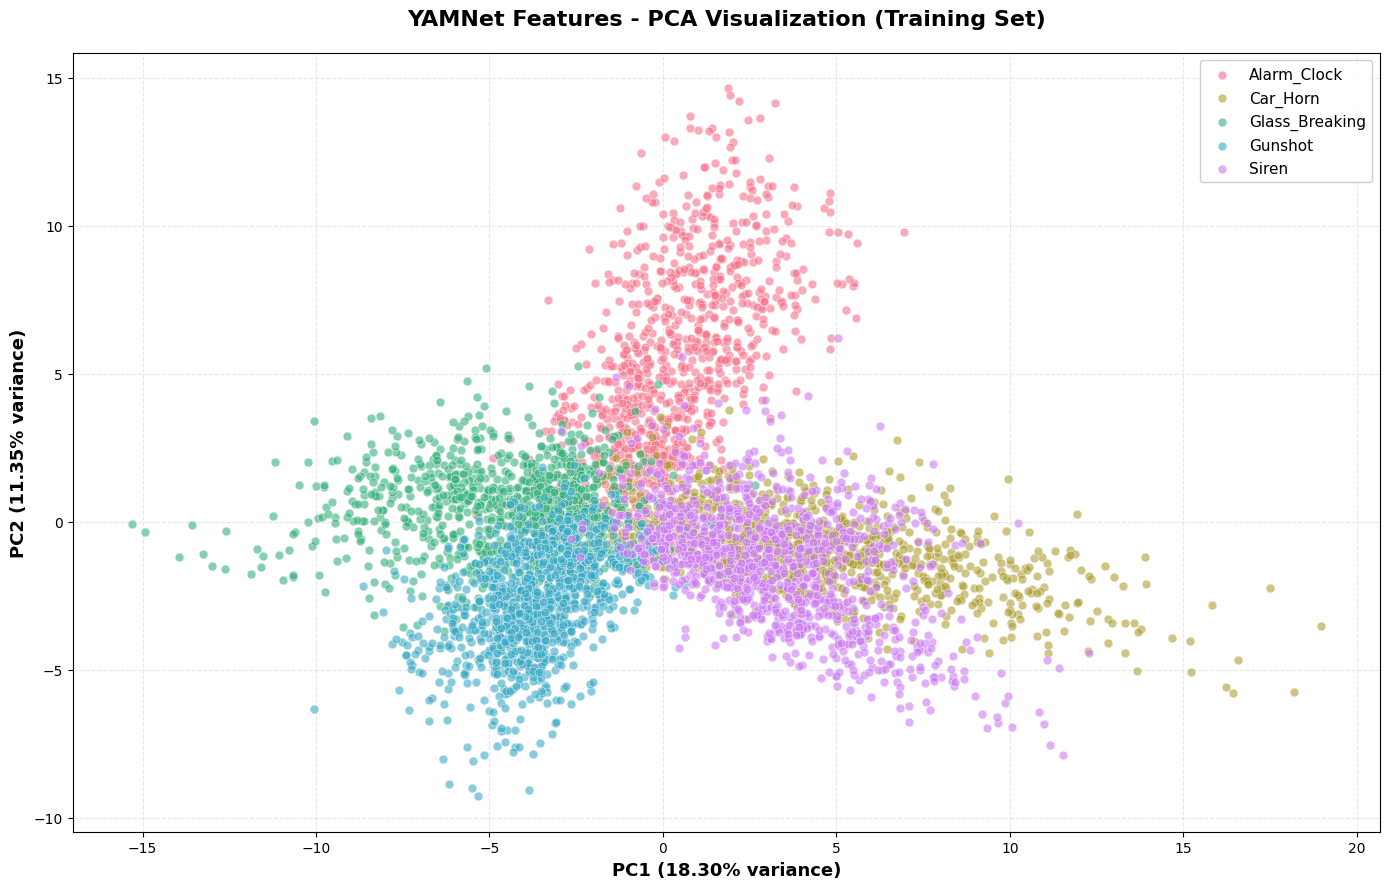

In [13]:
print("GENERATING VISUALIZATIONS (Training Set)")

X_train = splits_data['train']['X']
y_train = splits_data['train']['y']

# PCA Visualization
print("\nComputing PCA (1024 → 2 dimensions)...")
pca = PCA(n_components=2, random_state=RANDOM_SEED)
X_pca = pca.fit_transform(X_train)
print(f"PCA complete")
print(f"  PC1 variance explained: {pca.explained_variance_ratio_[0]:.2%}")
print(f"  PC2 variance explained: {pca.explained_variance_ratio_[1]:.2%}")
print(f"  Total variance explained: {pca.explained_variance_ratio_.sum():.2%}")

# Plot PCA
plt.figure(figsize=(14, 9))
categories = sorted(np.unique(y_train))
colors = sns.color_palette("husl", len(categories))

for idx, category in enumerate(categories):
    mask = y_train == category
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
                c=[colors[idx]], label=category, alpha=0.6, s=40,
                edgecolors='w', linewidth=0.5)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)',
           fontsize=13, fontweight='bold')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)',
           fontsize=13, fontweight='bold')
plt.title('YAMNet Features - PCA Visualization (Training Set)',
          fontsize=16, fontweight='bold', pad=20)
plt.legend(loc='best', framealpha=0.95, fontsize=11)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()

pca_path = os.path.join(FEATURES_DIR, 'train', 'pca_visualization.png')
plt.savefig(pca_path, dpi=300, bbox_inches='tight')
print(f"  Saved: {pca_path}")
plt.show()




Computing t-SNE visualization...
  Using 5,000 samples (this may take a few minutes)...
  t-SNE complete
  Saved: ../data/approach1/features\train\tsne_visualization.png


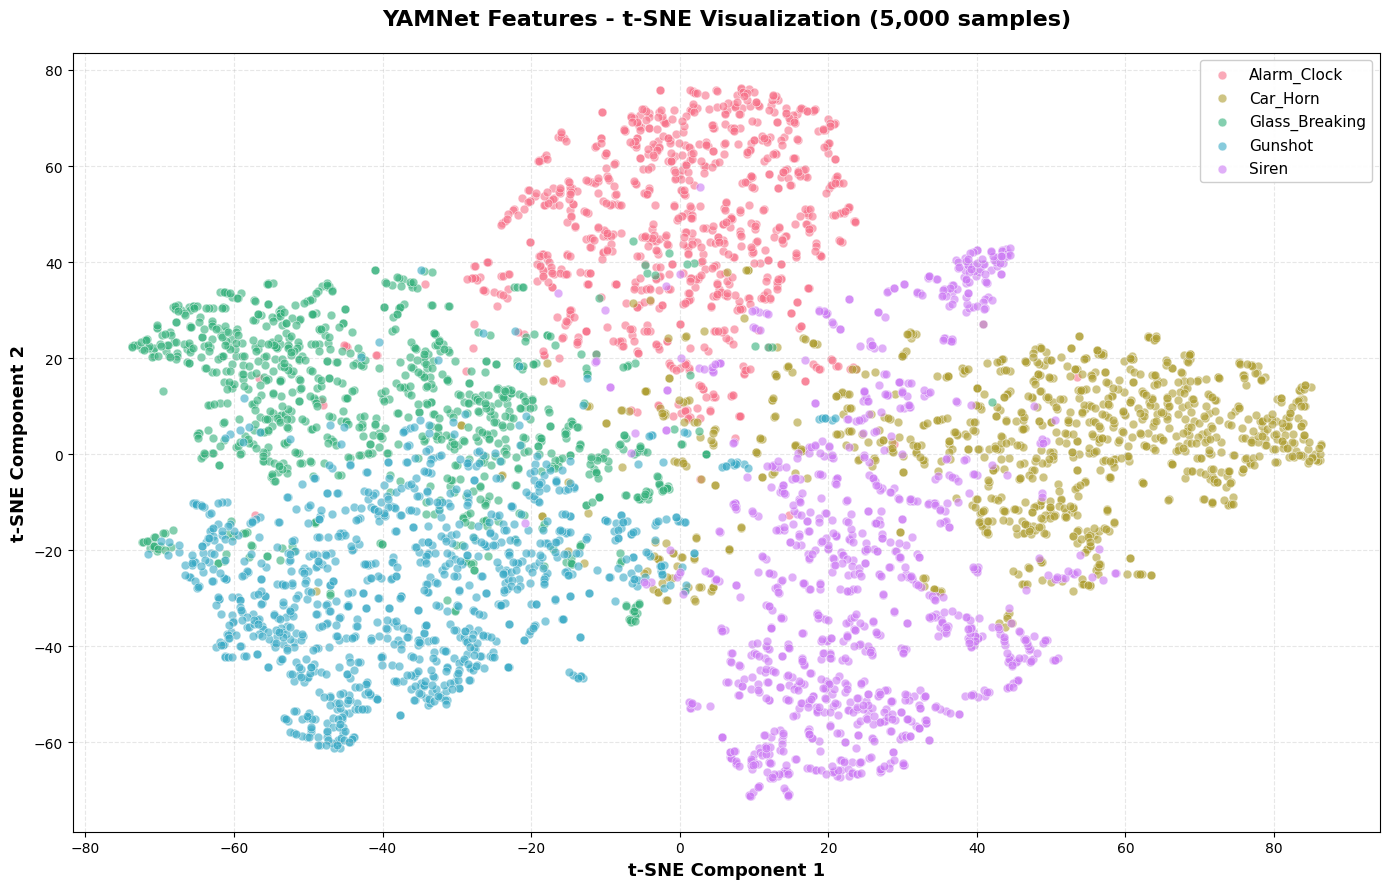

In [14]:
# t-SNE Visualization (on subset for efficiency)
print("\nComputing t-SNE visualization...")
subset_size = min(5000, len(X_train))
indices = np.random.choice(len(X_train), subset_size, replace=False)
X_subset = X_train[indices]
y_subset = y_train[indices]

print(f"  Using {subset_size:,} samples (this may take a few minutes)...")
tsne = TSNE(n_components=2, random_state=RANDOM_SEED,
            perplexity=30, n_iter=1000, verbose=0)
X_tsne = tsne.fit_transform(X_subset)
print("  t-SNE complete")

# Plot t-SNE
plt.figure(figsize=(14, 9))
for idx, category in enumerate(categories):
    mask = y_subset == category
    plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1],
                c=[colors[idx]], label=category, alpha=0.6, s=40,
                edgecolors='w', linewidth=0.5)

plt.xlabel('t-SNE Component 1', fontsize=13, fontweight='bold')
plt.ylabel('t-SNE Component 2', fontsize=13, fontweight='bold')
plt.title(f'YAMNet Features - t-SNE Visualization ({subset_size:,} samples)',
          fontsize=16, fontweight='bold', pad=20)
plt.legend(loc='best', framealpha=0.95, fontsize=11)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()

tsne_path = os.path.join(FEATURES_DIR, 'train', 'tsne_visualization.png')
plt.savefig(tsne_path, dpi=300, bbox_inches='tight')
print(f"  Saved: {tsne_path}")
plt.show()



In [15]:
# FINAL SUMMARY
print("\n" + "="*80)
print("EXTRACTION COMPLETE")
print("="*80)

print(f"\n{'Split':<10} {'Samples':<10} {'Features':<10} {'Categories':<15}")
print("-"*50)
total_samples = 0
for split in ['train', 'val', 'test']:
    data = splits_data[split]
    n_samples = data['X'].shape[0]
    n_features = data['X'].shape[1]
    n_categories = len(np.unique(data['y']))
    print(f"{split.capitalize():<10} {n_samples:<10} {n_features:<10} {n_categories:<15}")
    total_samples += n_samples

print("-"*50)
print(f"{'Total':<10} {total_samples:<10}")

print(f"\nAll features saved to: {FEATURES_DIR}")
print(f"  - {FEATURES_DIR}/train/")
print(f"  - {FEATURES_DIR}/val/")
print(f"  - {FEATURES_DIR}/test/")


EXTRACTION COMPLETE

Split      Samples    Features   Categories     
--------------------------------------------------
Train      5082       1024       5              
Val        714        1024       5              
Test       1306       1024       6              
--------------------------------------------------
Total      7102      

All features saved to: ../data/approach1/features
  - ../data/approach1/features/train/
  - ../data/approach1/features/val/
  - ../data/approach1/features/test/
